In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
sys.path.append('../../acd/acd')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
vector_cache = os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt')
word_vectors ='glove.6B.300d'
batch_size=  50


In [30]:
def makedirs(name):
    """helper function for python 2 and 3 to call os.makedirs()
       avoiding an error if the directory to be created already exists"""

    import os, errno

    try:
        os.makedirs(name)
    except OSError as ex:
        if ex.errno == errno.EEXIST and os.path.isdir(name):
            # ignore existing directory
            pass
        else:
            # a different error happened
            raise

In [31]:
sst_pkl = pickle.load(open('../../acd/dsets/sst/sst.pkl', 'rb'))

In [32]:
from os.path import isdir
sys.path.append('../../acd/visualization')
sys.path.append('../../acd/acd/util')
sys.path.append('../../acd/acd/scores')
sys.path.append('../../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
# form class to hold data
class B:
    text = torch.zeros(1).to(device)
sys.path.append('../../acd')
sys.path.append('../../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment

# check out how two models differ
import torch.optim as O
import torch.nn as nn

from torchtext import data
from torchtext import datasets

In [34]:

inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

inputs.build_vocab(train, dev, test)
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        makedirs(os.path.dirname(vector_cache))
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits(
    (train, dev, test), batch_size=batch_size, device=torch.device(0))

In [35]:
model_path = "../../acd/dsets/sst/results"
model_list = os.listdir(model_path)

In [36]:
from os.path import join

In [38]:

model1 = torch.load('../models/model1.pt', map_location=torch.device(0))
model2 = torch.load('../models/model2.pt', map_location=torch.device(0))

In [120]:
torch.no_grad()

In [115]:
model1.eval()
model2.eval()

LSTMSentiment(
  (embed): Embedding(18844, 300)
  (lstm): LSTM(300, 128)
  (hidden_to_label): Linear(in_features=128, out_features=2, bias=True)
)

# Relation between output and explanation divergence


In [125]:
def kl_divergence(in1, in2):
    a= (in1-in2)
    b = (torch.log(in1) - torch.log(in2))

    return (a*b).sum(dim=1).cpu().detach().numpy()

In [181]:
num_batches = 17
output_div = np.empty((num_batches*batch_size))
expl_div = np.empty((num_batches*batch_size))

In [183]:
# Model 2
dev_iter.init_epoch()
# check out how two models differ
import torch.optim as O
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
n_dev_correct, dev_loss = 0, 0
cur_idx = 0
for dev_batch_idx, dev_batch in enumerate(dev_iter):
    if dev_batch_idx>num_batches-1:
        break
    answer1 = model1(dev_batch)
    answer2 = model2(dev_batch)
    batch_length = dev_batch.text.shape[0]
    batch_num = dev_batch.text.shape[1]
    test = kl_divergence(torch.nn.functional.softmax(answer1, dim = 1), torch.nn.functional.softmax(answer2, dim = 1))

    output_div[cur_idx:cur_idx+batch_num] = kl_divergence(torch.nn.functional.softmax(answer1, dim = 1), torch.nn.functional.softmax(answer2, dim = 1))

    start = np.random.randint(batch_length-1)
    stop = start + np.random.randint(batch_length-start)
    model1_rel, model1_irrel =cd.cd_batch_text(dev_batch, model1, start, stop)
    model2_rel, model2_irrel =cd.cd_batch_text(dev_batch, model2, start, stop)
    model1_softmax = torch.nn.functional.softmax(torch.stack((model1_rel.view(-1),model1_irrel.view(-1)), 1), dim = 1)
    model2_softmax = torch.nn.functional.softmax(torch.stack((model2_rel.view(-1),model2_irrel.view(-1)), 1), dim = 1)
    expl_div[cur_idx:cur_idx+batch_num] =  ((model1_softmax-model2_softmax)*
                (torch.log(model1_softmax) - torch.log(model2_softmax))).sum(dim=1).view((2,dev_batch.text.shape[1],)).sum(dim=0).cpu().detach().numpy()
    
    cur_idx+=dev_batch.label.shape[0]
    n_dev_correct += (((torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).sum()
    dev_loss = criterion(answer2, dev_batch.label)
# dev_acc = 100. * n_dev_correct / len(dev)
# print(dev_acc.item(), dev_loss.item())

In [184]:
output_div -= output_div.mean()
output_div/=output_div.std()
expl_div -=expl_div.mean()
expl_div /=expl_div.std()

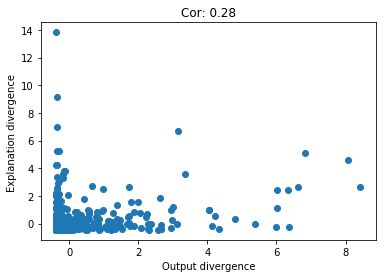

In [185]:
plt.scatter(output_div, expl_div)
plt.ylabel("Explanation divergence ")
plt.xlabel("Output divergence")
plt.title("Cor: {}".format(np.cov(output_div, expl_div)[0,1].round(decimals=2)));

In [ ]:
hvad vil vi?
average divergence mapped over average difference 